# Estimating posterior probability of feature (P(LayerInterface))

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split

import numpy as np
import os
import time
import h5py
from urllib.request import urlretrieve as urlretrieve

import matplotlib.pyplot as plt

## (Down)load data

nm= 125
nd= 12
(134000, 125)
(134000, 12)
(66001, 125)
(66001, 12)


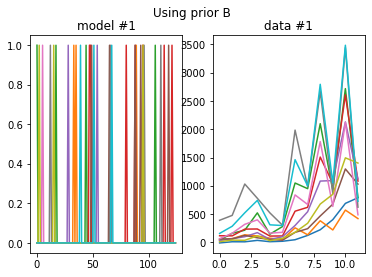

In [2]:
usePrior = 'B'
if (usePrior=='A'):
    file_training = '1D_P14_NO500_451_ABC200001_1000.h5'
    file_sampling = '1D_P14_NO500_451_ABC200001_1000_ME1_aT1_CN1.h5'
elif (usePrior=='B'):
    file_training = '1D_P51_NO500_451_ABC200001_1000.h5'
    file_sampling = '1D_P51_NO500_451_ABC200001_1000_ME1_aT1_CN1.h5'
elif (usePrior=='C'):
    file_training = '1D_P22_NO500_451_ABC200001_1000.h5'
    file_sampling = '1D_P22_NO500_451_ABC200001_1000_ME1_aT1_CN1.h5'

# Download if h5 files does not exist    
if not os.path.exists(file_training):
  print("Downloading %s" % (file_training))
  urlretrieve("https://github.com/cultpenguin/probabilistic-inverse-problems_and_ml/raw/main/%s" % (file_training),file_training)
if not os.path.exists(file_sampling):
  print("Downloading %s" % (file_sampling))
  urlretrieve("https://github.com/cultpenguin/probabilistic-inverse-problems_and_ml/raw/main/%s" % (file_sampling),file_sampling)    
        
f_training = h5py.File(file_training, 'r')
f_sampling = h5py.File(file_sampling, 'r')

#print(list(f_sampling.keys()))
#print(list(f_training.keys()))

M = f_training['M3'][:]  # LayerInertface ([0;1])
D = f_training['D2'][:]  # Data with noise

nd=D.shape[1]
nm=M.shape[1]
print('nm= %d' % nm)
print('nd= %d' % nd)
plt.subplot(1,2,1)
plt.plot(M[0:10,:].T)
plt.title('model #1')
plt.subplot(1,2,2)
plt.title('data #1')
plt.plot(D[0:10,:].T)
plt.suptitle('Using prior %s' % (usePrior))

# split data into training and validation data
m_train, m_test, d_train, d_test = train_test_split(M,D, test_size=0.33, random_state=42)
print(m_train.shape)
print(d_train.shape)
print(m_test.shape)
print(d_test.shape)



## Setup neural network

In [3]:
# Setuyp the network 
nhidden=3
nunits=40
learning_rate=1e-3

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(nunits, input_dim=nd, kernel_initializer='normal', activation='relu'))
for i in range(nhidden):
    model.add(tf.keras.layers.Dense(nunits, activation='relu'))
model.add(tf.keras.layers.Dense(nm, activation='sigmoid'))

#optim = tf.keras.optimizers.Adamax()
optim = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optim,
          loss=tf.keras.losses.BinaryCrossentropy(),
          metrics=['accuracy'])

# Print model info
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                520       
_________________________________________________________________
dense_1 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_4 (Dense)              (None, 125)               5125      
Total params: 10,565
Trainable params: 10,565
Non-trainable params: 0
_________________________________________________________________


## Train the network

In [4]:
try:
    %load_ext tensorboard
    %tensorboard --logdir logs
except:
    print("No iPython")


Reusing TensorBoard on port 6006 (pid 100920), started 1:15:57 ago. (Use '!kill 100920' to kill it.)

Training neural network
Logs in logs/PriorB_Pfeature_bs64_ep11_nh3_nu40
Epoch 1/11
2094/2094 [==============================] - 7s 3ms/step - loss: 0.1510 - accuracy: 0.0133 - val_loss: 0.1119 - val_accuracy: 0.0036
Epoch 2/11
2094/2094 [==============================] - 7s 3ms/step - loss: 0.1111 - accuracy: 0.0167 - val_loss: 0.1108 - val_accuracy: 0.0152
Epoch 3/11
2094/2094 [==============================] - 7s 3ms/step - loss: 0.1092 - accuracy: 0.0282 - val_loss: 0.1079 - val_accuracy: 0.0443
Epoch 4/11
2094/2094 [==============================] - 6s 3ms/step - loss: 0.1080 - accuracy: 0.0331 - val_loss: 0.1076 - val_accuracy: 0.0270
Epoch 5/11
2094/2094 [==============================] - 7s 3ms/step - loss: 0.1072 - accuracy: 0.0354 - val_loss: 0.1066 - val_accuracy: 0.0308
Epoch 6/11
2094/2094 [==============================] - 7s 3ms/step - loss: 0.1066 - accuracy: 0.0391 - val_loss: 0.1058 - val_accuracy: 0.0373
Epoch 7/11
2094/2094 [==============================] - 7s 3ms/s

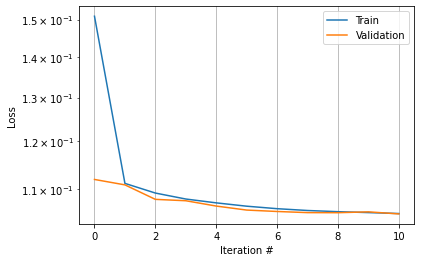

In [5]:
batch_size=64
n_epochs=10000
patience = 50
fout='Prior%s_Pfeature_bs%d_ep%d_nh%d_nu%d' % (usePrior,batch_size,n_epochs,nhidden,nunits)

model_h5 = fout + '.h5'

if (os.path.isfile(model_h5)):
    # Neural net has allready been trained
    print('Neural network has allready been trained - loading weights from %s' % (model_h5))
    model.load_weights(model_h5)

else:
    # Neural net has not been trained
    print('Training neural network')
    
    # Tensorboard
    logdir = os.path.join("logs" , fout )
    print("Logs in %s" % (logdir) )
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, profile_batch=0)
    
    # Early stopping
    earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=3)
    
    t0=time.time()

    out = model.fit(d_train, m_train, 
            epochs=n_epochs, 
            batch_size=batch_size,
            verbose=1,
            validation_data=(d_test,m_test),
            callbacks=[tensorboard_callback,earlystopping_callback])

    t1=time.time()
    t_train=t1-t0
    print("Elapsed time for training = %3.1fs" % (t_train))

    # Save h5 model
    print('%s: Save model weights' % (fout))
    #tf.keras.models.save_model(model, model_h5, save_format='h5')    
    model.save_weights(model_h5)

    # Plot loss
    plt.figure(1)
    plt.semilogy(out.history['loss'], label='Train')
    plt.semilogy(out.history['val_loss'], label='Validation')
    plt.xlabel('Iteration #')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    

## Predict posterior mean and standard deviation

In [6]:
# load observed data
D_obs= f_sampling['D_obs'][:]
n_est = D_obs.shape[0]

#t0=time.time()
#POST = model(D_obs)
#M_mean = POST.mean().numpy().T
#M_std = POST.stddev().numpy().T
#t1=time.time()
#t_pred = t1-t0;

t0=time.time()
POST = model(D_obs)
P_layer=POST.numpy().T
t1=time.time()
t_pred=t1-t0


print('prediction time: %5.1fms / %d models' % (1000*t_pred, n_est))
print('prediction time: %4.0f modsels/s' % (1/(t_pred/n_est)))

print(list(f_sampling.keys()))


prediction time:   2.6ms / 451 models
prediction time: 171951 modsels/s
['D_obs', 'D_std', 'M_est', 'M_lith1', 'M_lith2', 'M_lith3', 'M_prob_layer', 'M_std']


## Plot some figures

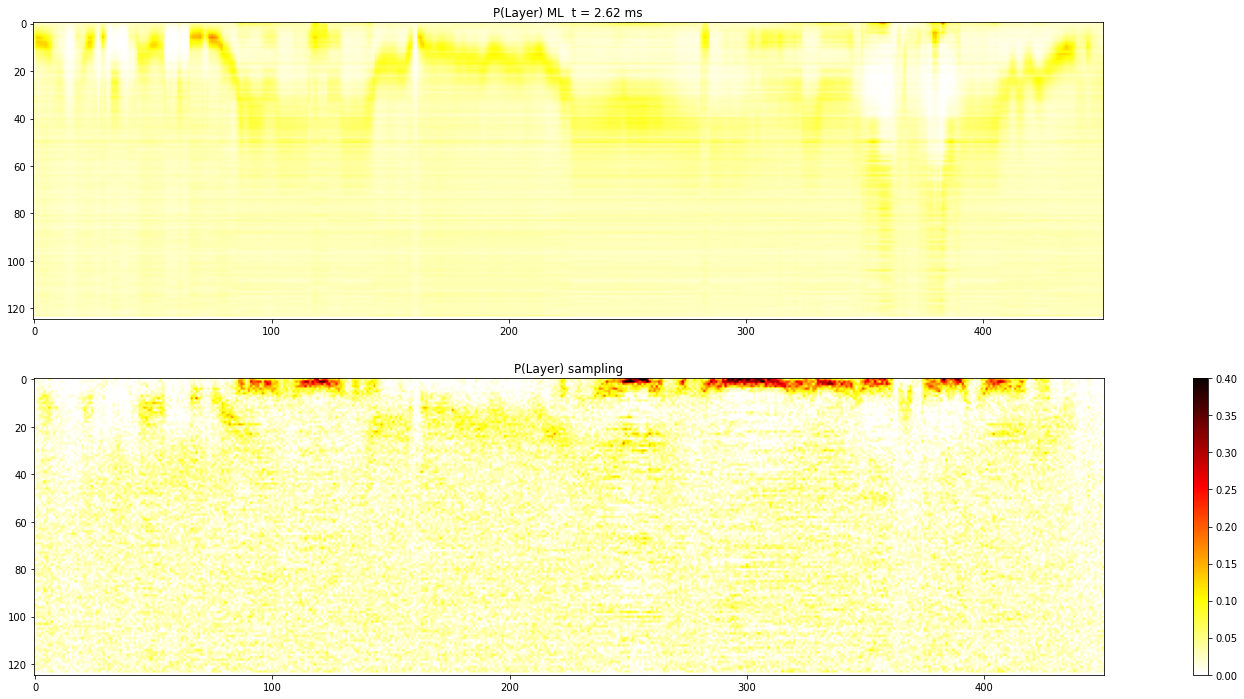

In [7]:
# load mean and sdt obtained using sampling
P_layer_sampling = f_sampling['M_prob_layer'][:].T





plt.figure(figsize=(32,12))
plt.subplot(211)
plt.imshow(P_layer, vmin=0, vmax=0.4, cmap=plt.cm.get_cmap('hot').reversed())
plt.title('P(Layer) ML  t = %4.2f ms' % (1000*t_pred))

plt.subplot(212)
plt.imshow(P_layer_sampling, vmin=0, vmax=0.4, cmap=plt.cm.get_cmap('hot').reversed())
plt.title('P(Layer) sampling')
plt.colorbar()
plt.savefig(fout + '_Player')    

